In [1]:
import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')

import trecs

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict
from chaney_utils import (
    load_sim_results,
    graph_relative_to_ideal,
    merge_results,
    graph_metrics,
    graph_metrics_by_axis,
    graph_relative_to_global_by_axis
)
import warnings
warnings.simplefilter("ignore")

import itertools

/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research/param_experiments/chaney_utils.py:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if model_key is "ideal" and not absolute_measure:


In [2]:
DEBUG = True # don't save figures

In [3]:
# results = merge_results(["param_exp_results/repeated_training", "param_exp_results/single_training"])

results_path = "param_exp_results/50train50run"

results = merge_results([results_path])
print(results.keys())

model_keys = ['0.0drift_0attention_0retraining', '0.0drift_0attention_1retraining', '0.0drift_-0.8attention_0retraining', '0.0drift_-0.8attention_1retraining', '0.05drift_0attention_0retraining', '0.05drift_0attention_1retraining', '0.05drift_-0.8attention_0retraining', '0.05drift_-0.8attention_1retraining', '0.1drift_0attention_0retraining', '0.1drift_0attention_1retraining', '0.1drift_-0.8attention_0retraining', '0.1drift_-0.8attention_1retraining']
print(model_keys)

id_to_readable = dict(zip(model_keys, model_keys))
print(id_to_readable)

dict_keys(['mse', 'interaction_spread', 'global_interaction_similarity', 'inter_cluster_interaction_similarity', 'intra_cluster_interaction_similarity'])
['0.0drift_0attention_0retraining', '0.0drift_0attention_1retraining', '0.0drift_-0.8attention_0retraining', '0.0drift_-0.8attention_1retraining', '0.05drift_0attention_0retraining', '0.05drift_0attention_1retraining', '0.05drift_-0.8attention_0retraining', '0.05drift_-0.8attention_1retraining', '0.1drift_0attention_0retraining', '0.1drift_0attention_1retraining', '0.1drift_-0.8attention_0retraining', '0.1drift_-0.8attention_1retraining']
{'0.0drift_0attention_0retraining': '0.0drift_0attention_0retraining', '0.0drift_0attention_1retraining': '0.0drift_0attention_1retraining', '0.0drift_-0.8attention_0retraining': '0.0drift_-0.8attention_0retraining', '0.0drift_-0.8attention_1retraining': '0.0drift_-0.8attention_1retraining', '0.05drift_0attention_0retraining': '0.05drift_0attention_0retraining', '0.05drift_0attention_1retraining': '0

In [4]:
hyper_params = {"drift":[0.0, 0.05, 0.1], "attention_exp":[0, -0.8], "repeated_training":[0,1]}
models = dict([(f"{p[0]}drift_{p[1]}attention_{p[2]}retraining", p) for p in itertools.product(*hyper_params.values())])

results_df = pd.DataFrame(columns=["drift", "attention_exp", "repeated_training"] + list(results.keys()))
results_df

for params in model_keys:
    df = pd.DataFrame(columns=["drift", "attention_exp", "repeated_training"] + list(results.keys()))
    for metric in results:
        metric_results = [vals for sim_trial in results[metric][params] for vals in sim_trial]
        df[metric] = metric_results
    df["drift"] = models[params][0]
    df["attention_exp"] = models[params][1]
    df["repeated_training"] = models[params][2]
    results_df = pd.concat([results_df, df])

In [5]:
print(results_df.shape)
results_df.head()
# len(models)

(3600, 8)


,drift,attention_exp,repeated_training,mse,interaction_spread,global_interaction_similarity,inter_cluster_interaction_similarity,intra_cluster_interaction_similarity
0,0.0,0,0,0.090065,-939.0,0.001668,0.001494,0.001995
1,0.0,0,0,0.090065,-0.5,0.002110,0.001912,0.002480
2,0.0,0,0,0.090065,0.5,0.002889,0.002620,0.003395
3,0.0,0,0,0.090065,-0.5,0.003732,0.003433,0.004293
4,0.0,0,0,0.090065,0.0,0.004493,0.004159,0.005120


In [6]:
y_labels = dict([("mse", "mse"), ("interaction_spread", "interaction spread"), ("global_interaction_similarity", "average jacard similarity"), ("inter_cluster_interaction_similarity", "average jacard similarity"), ("intra_cluster_interaction_similarity", "average jacard similarity")])

model_key_pairs = [(model_keys[i], model_keys[i+1]) for i in range(0, len(model_keys), 2)]

single_training_keys = [key[0] for key in model_key_pairs]
repeated_training_keys = [key[1] for key in model_key_pairs]

# Graphing `MSE`

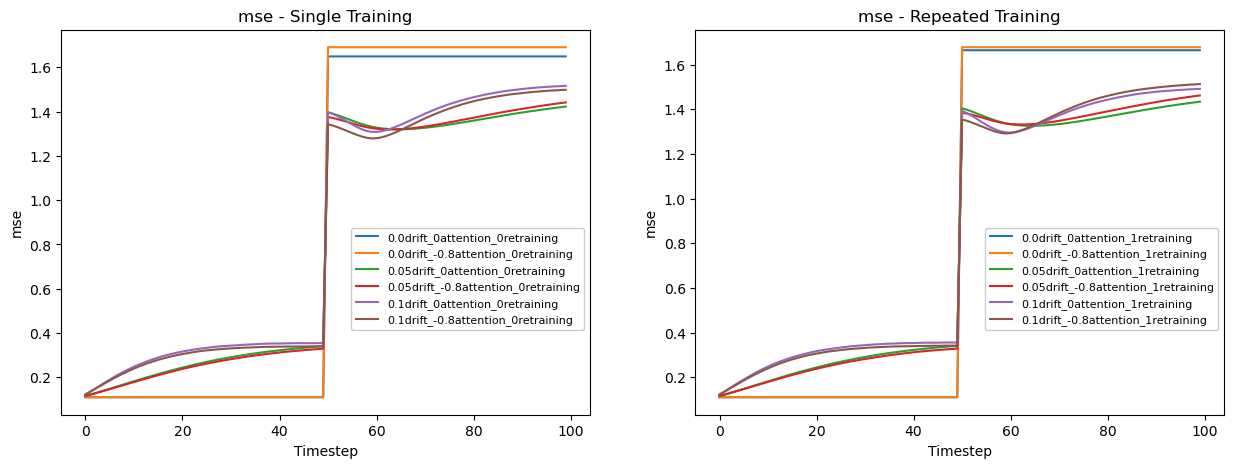

In [7]:
metric_key = "mse"

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

graph_metrics_by_axis(axs[0], results, metric_key, single_training_keys, id_to_readable, mult_sd=0)
axs[0].set_ylabel(y_labels[metric_key])
axs[0].set_xlabel("Timestep")
axs[0].set_title(f"{metric_key} - Single Training")
axs[0].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.5), fontsize="8",)

graph_metrics_by_axis(axs[1], results, metric_key, repeated_training_keys, id_to_readable, mult_sd=0)
axs[1].set_ylabel(y_labels[metric_key])
axs[1].set_xlabel("Timestep")
axs[1].set_title(f"{metric_key} - Repeated Training")
axs[1].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.5), fontsize="8",)

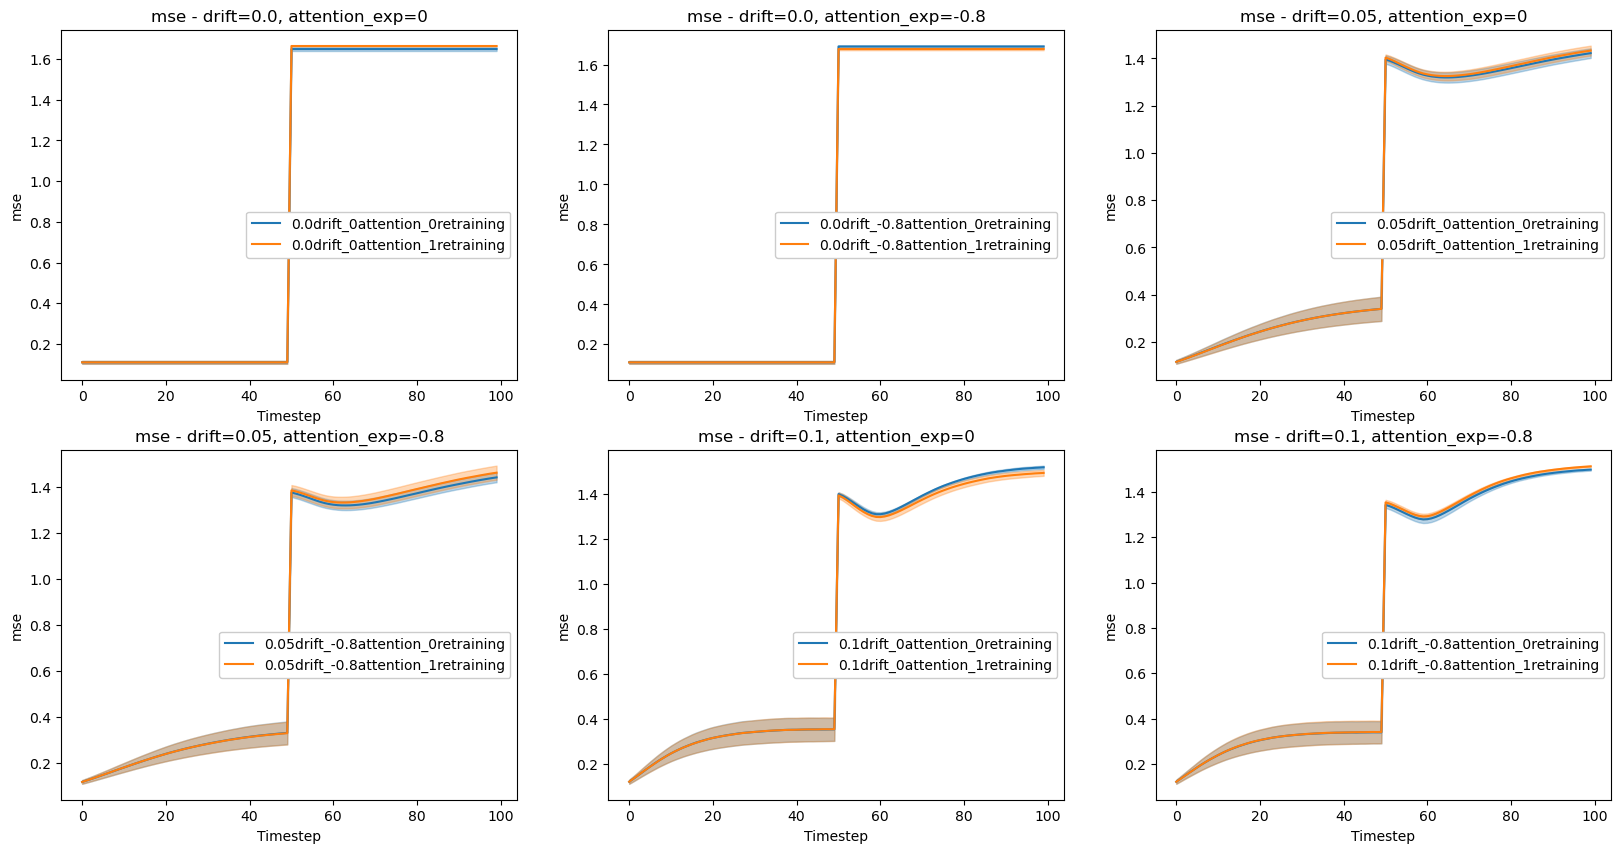

In [8]:
metric_key = "mse"

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i in range(len(model_key_pairs)):
    curr_ax = axs[int(i >= 3), i%3]
    graph_metrics_by_axis(curr_ax, results, metric_key, model_key_pairs[i], id_to_readable, mult_sd=0.5)
    curr_ax.set_ylabel(y_labels[metric_key])
    curr_ax.set_xlabel("Timestep")
    curr_ax.set_title(f"{metric_key} - drift={models[model_key_pairs[i][0]][0]}, attention_exp={models[model_key_pairs[i][0]][1]}")

In [9]:
# single_training_keys = ['0.0drift_0attention_0retraining', '0.0drift_-0.8attention_0retraining', '0.05drift_0attention_0retraining', '0.05drift_-0.8attention_0retraining', '0.1drift_0attention_0retraining', '0.1drift_-0.8attention_0retraining']
# print(single_training_keys)

# metric_key = "mse"
# # graph_relative_to_ideal(results, "mse", single_training_keys, id_to_readable, absolute_measure=False, mult_sd=1.0)
# graph_metrics(results, metric_key, single_training_keys, id_to_readable, mult_sd=0.5)
# plt.ylabel(y_labels[metric_key])
# plt.xlabel("Timestep")
# plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
# plt.ylim(-0.1, 1.75)
# plt.xlim(0, 60)
# plt.title(f"Single Training - {metric_key}")
# if not DEBUG:
#     plt.savefig("figures/repeated_training_sim_pair.pdf", bbox_inches = "tight")
    
# repeated_training_keys = list(set(model_keys) - set(single_training_keys))
# print(repeated_training_keys)

# metric_key = "mse"
# # graph_relative_to_ideal(results, "mse", single_training_keys, id_to_readable, absolute_measure=False, mult_sd=1.0)
# graph_metrics(results, metric_key, repeated_training_keys, id_to_readable, mult_sd=0.5)
# plt.ylabel("Change in Jaccard Index")
# plt.xlabel("Timestep")
# plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
# plt.ylim(-0.1, 1.75)
# plt.xlim(0, 60)
# plt.title(f"Repeated Training - {metric_key}")
# if not DEBUG:
#     plt.savefig("figures/repeated_training_sim_pair.pdf", bbox_inches = "tight")

# Graphing `Global Interaction Similarity`

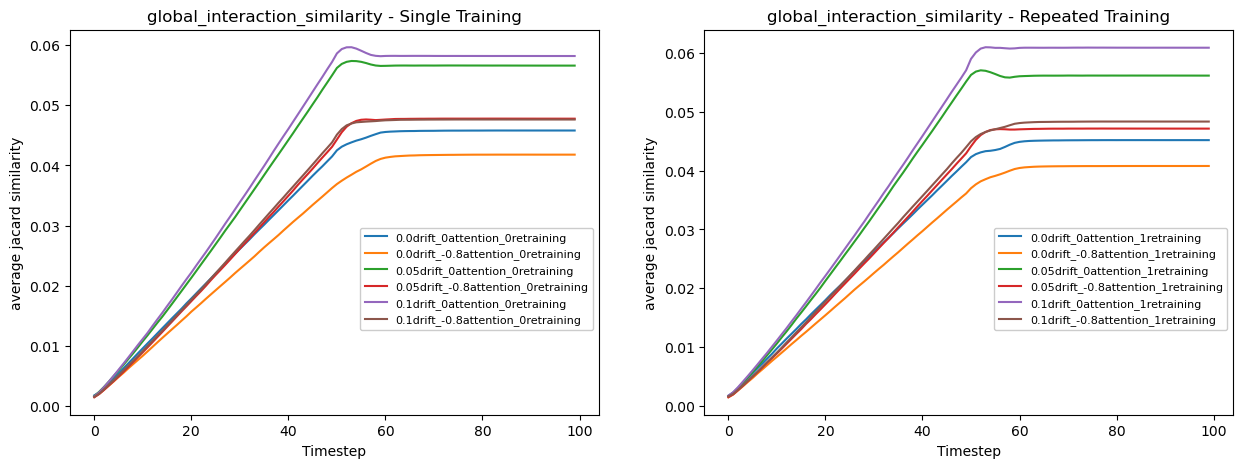

In [10]:
metric_key = "global_interaction_similarity"

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

graph_metrics_by_axis(axs[0], results, metric_key, single_training_keys, id_to_readable, mult_sd=0)
axs[0].set_ylabel(y_labels[metric_key])
axs[0].set_xlabel("Timestep")
axs[0].set_title(f"{metric_key} - Single Training")
axs[0].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.5), fontsize="8",)

graph_metrics_by_axis(axs[1], results, metric_key, repeated_training_keys, id_to_readable, mult_sd=0)
axs[1].set_ylabel(y_labels[metric_key])
axs[1].set_xlabel("Timestep")
axs[1].set_title(f"{metric_key} - Repeated Training")
axs[1].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.5), fontsize="8",)

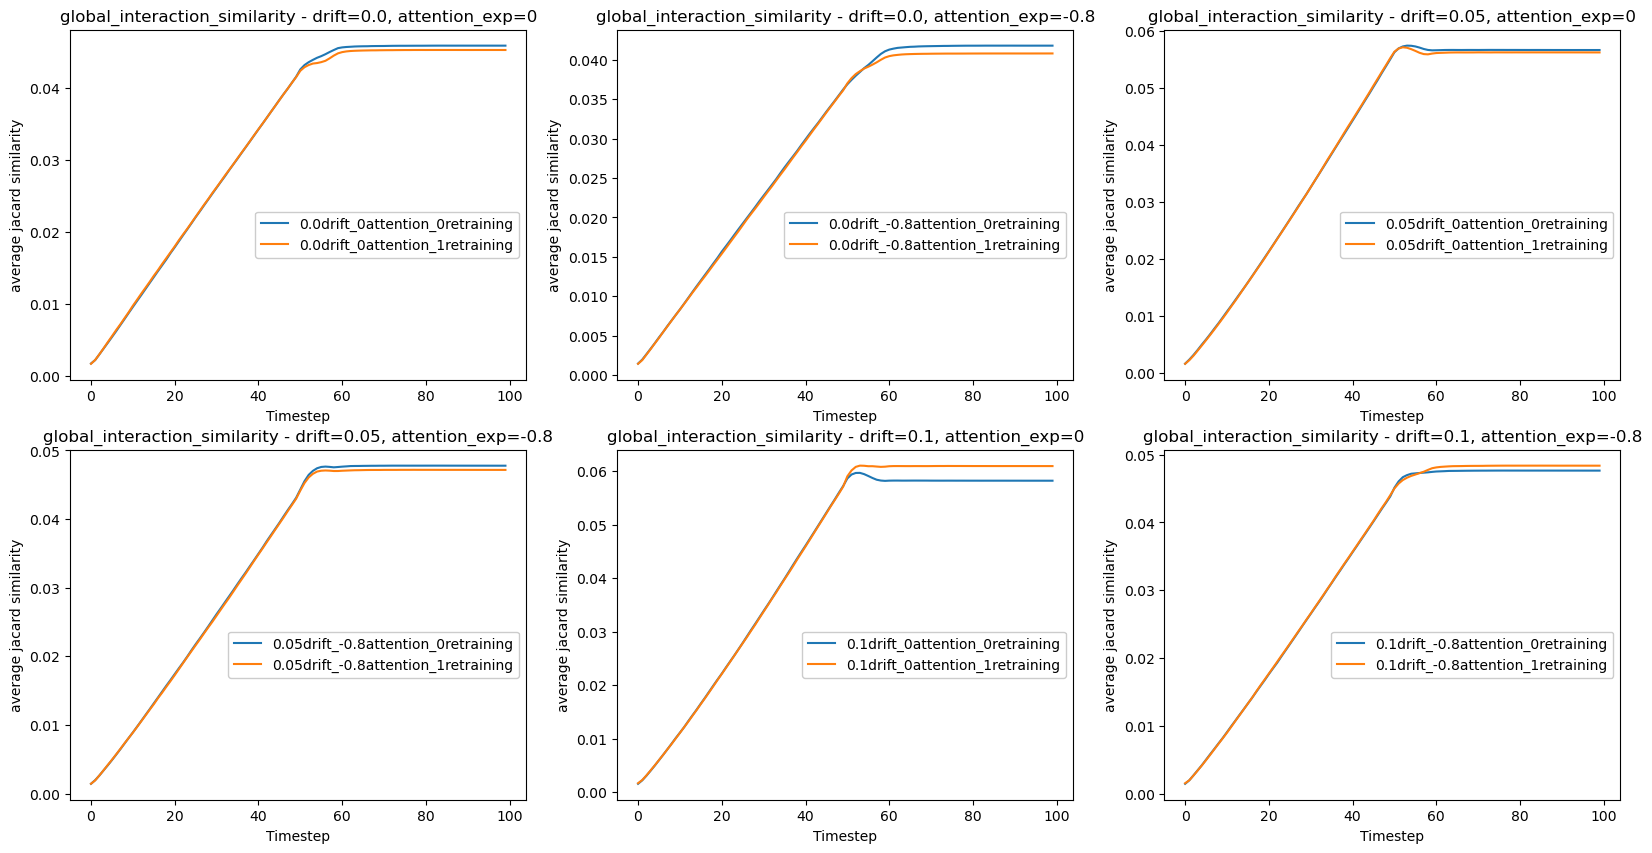

In [11]:
metric_key = "global_interaction_similarity"

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i in range(len(model_key_pairs)):
    curr_ax = axs[int(i >= 3), i%3]
    graph_metrics_by_axis(curr_ax, results, metric_key, model_key_pairs[i], id_to_readable, mult_sd=0)
    curr_ax.set_ylabel(y_labels[metric_key])
    curr_ax.set_xlabel("Timestep")
    curr_ax.set_title(f"{metric_key} - drift={models[model_key_pairs[i][0]][0]}, attention_exp={models[model_key_pairs[i][0]][1]}")

# Graphing **`Inter`** `-Cluster Interaction Similarity`

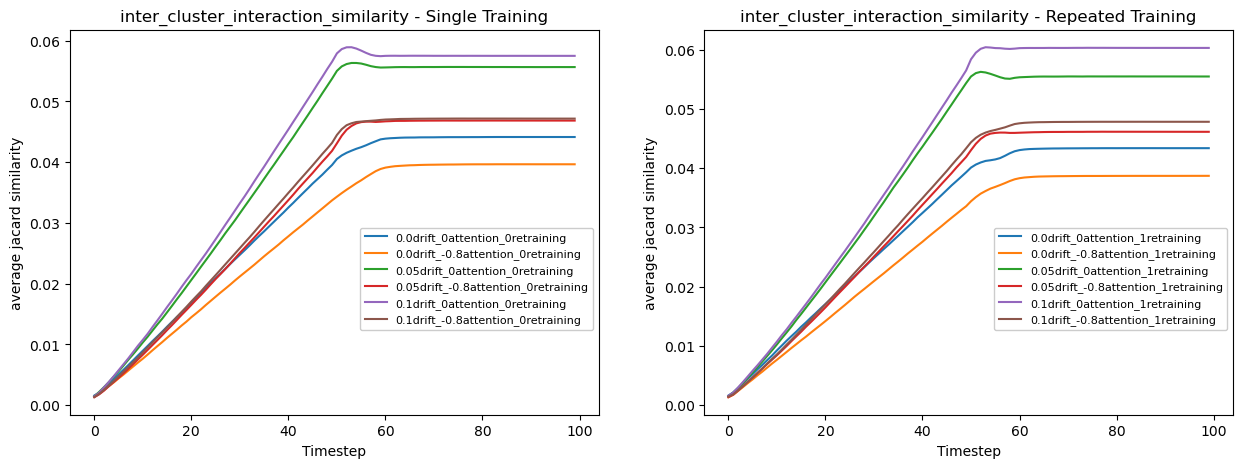

In [12]:
metric_key = "inter_cluster_interaction_similarity"

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

graph_metrics_by_axis(axs[0], results, metric_key, single_training_keys, id_to_readable, mult_sd=0)
axs[0].set_ylabel(y_labels[metric_key])
axs[0].set_xlabel("Timestep")
axs[0].set_title(f"{metric_key} - Single Training")
axs[0].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.5), fontsize="8",)

graph_metrics_by_axis(axs[1], results, metric_key, repeated_training_keys, id_to_readable, mult_sd=0)
axs[1].set_ylabel(y_labels[metric_key])
axs[1].set_xlabel("Timestep")
axs[1].set_title(f"{metric_key} - Repeated Training")
axs[1].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.5), fontsize="8",)

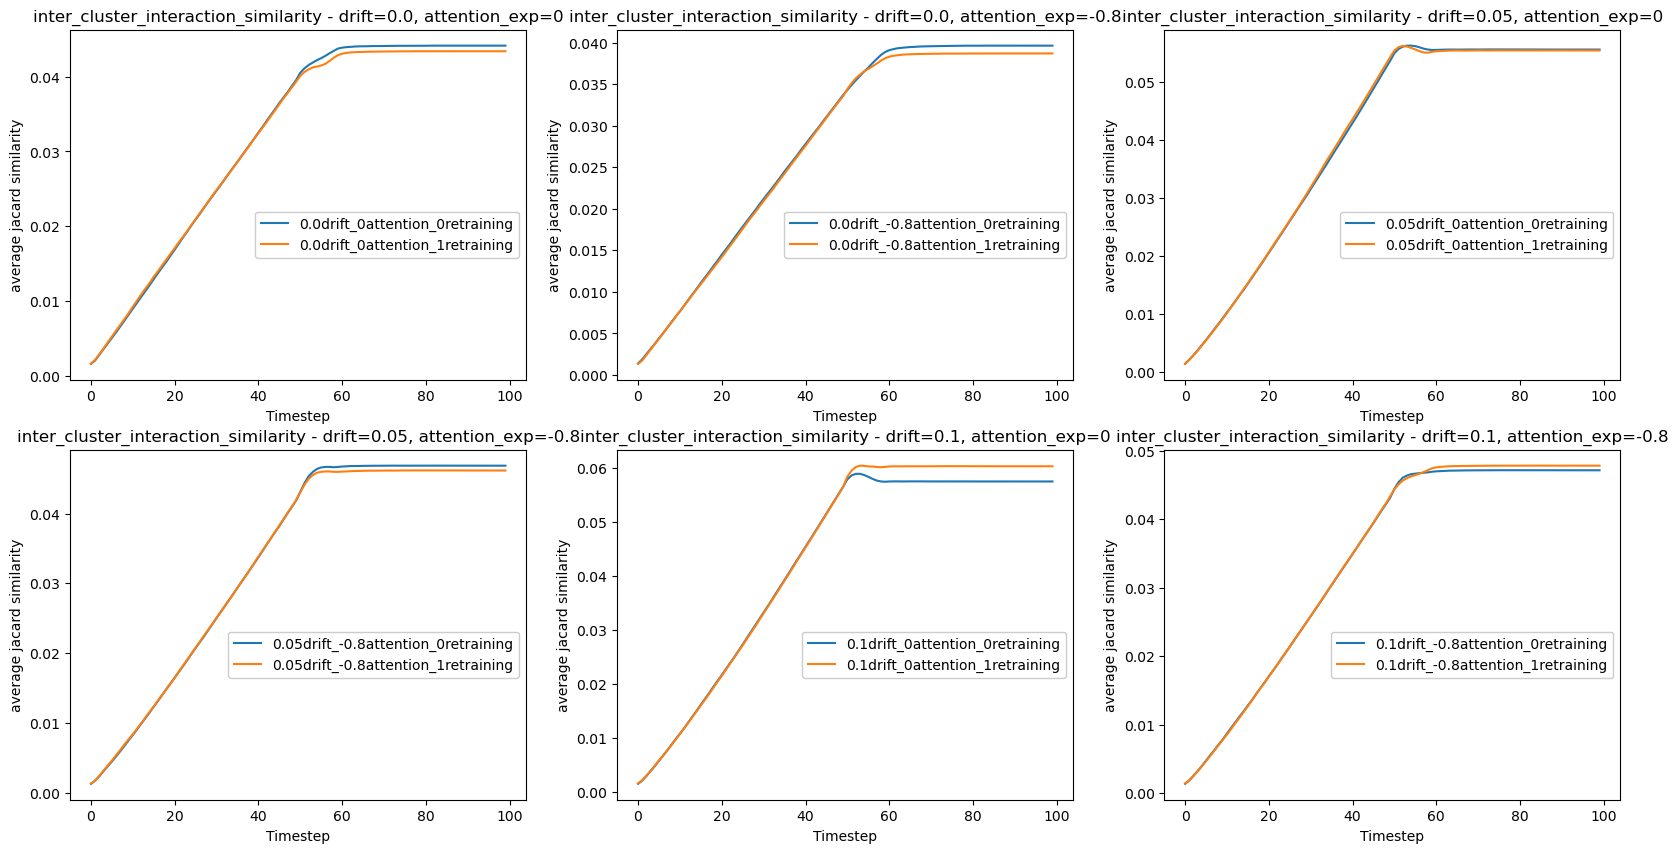

In [13]:
metric_key = "inter_cluster_interaction_similarity"

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i in range(len(model_key_pairs)):
    curr_ax = axs[int(i >= 3), i%3]
    graph_metrics_by_axis(curr_ax, results, metric_key, model_key_pairs[i], id_to_readable, mult_sd=0)
    curr_ax.set_ylabel(y_labels[metric_key])
    curr_ax.set_xlabel("Timestep")
    curr_ax.set_title(f"{metric_key} - drift={models[model_key_pairs[i][0]][0]}, attention_exp={models[model_key_pairs[i][0]][1]}")

# Graphing **`Intra`** `-Cluster Interaction Similarity`

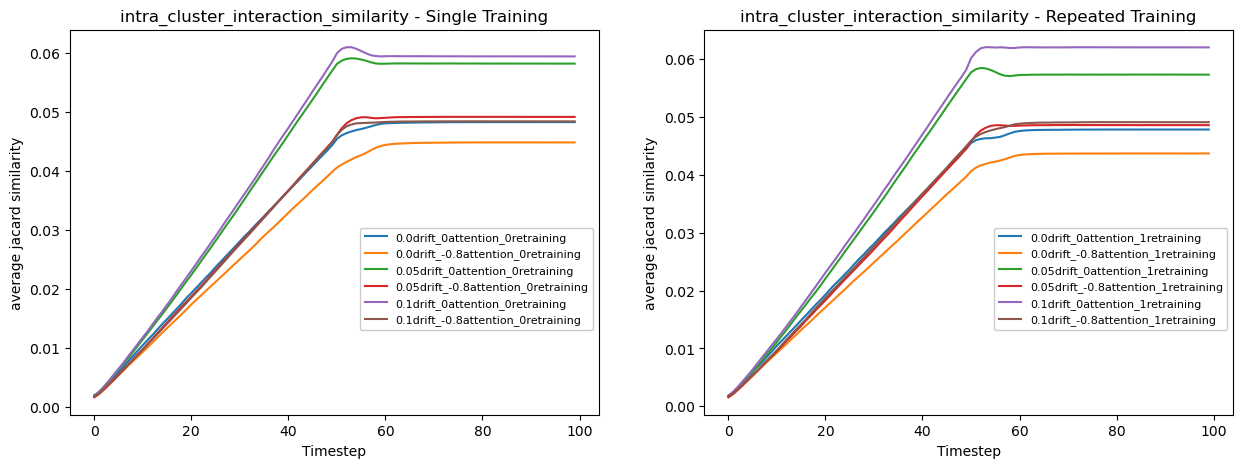

In [14]:
metric_key = "intra_cluster_interaction_similarity"

single_training_keys = [key[0] for key in model_key_pairs]
repeated_training_keys = [key[1] for key in model_key_pairs]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

graph_metrics_by_axis(axs[0], results, metric_key, single_training_keys, id_to_readable, mult_sd=0)
axs[0].set_ylabel(y_labels[metric_key])
axs[0].set_xlabel("Timestep")
axs[0].set_title(f"{metric_key} - Single Training")
axs[0].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.5), fontsize="8",)

graph_metrics_by_axis(axs[1], results, metric_key, repeated_training_keys, id_to_readable, mult_sd=0)
axs[1].set_ylabel(y_labels[metric_key])
axs[1].set_xlabel("Timestep")
axs[1].set_title(f"{metric_key} - Repeated Training")
axs[1].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.5), fontsize="8",)

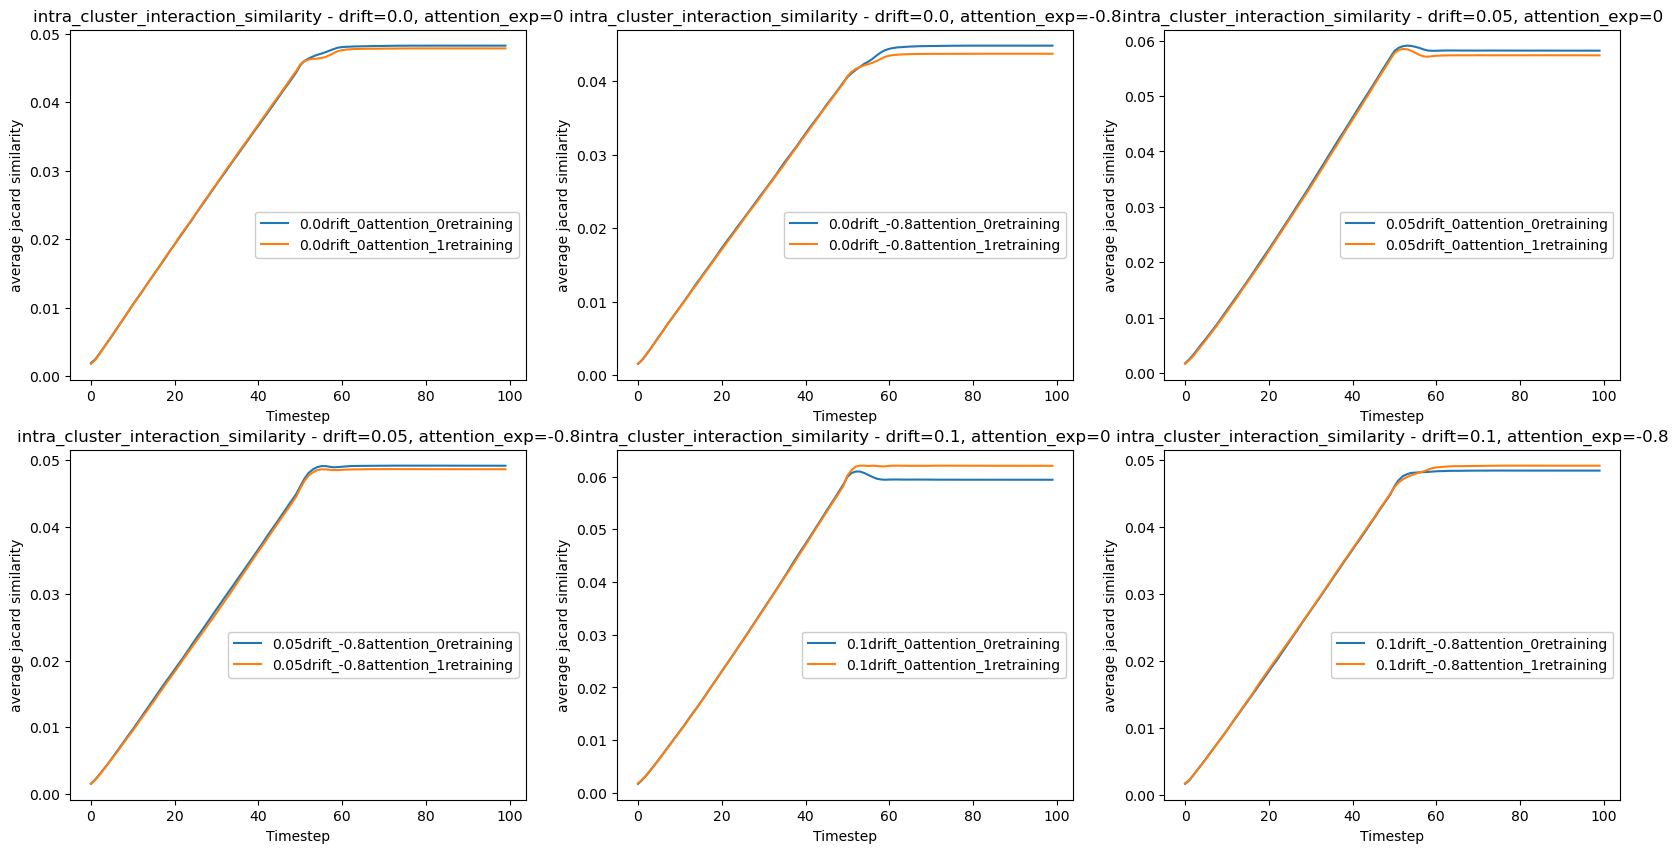

In [15]:
metric_key = "intra_cluster_interaction_similarity"

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i in range(len(model_key_pairs)):
    curr_ax = axs[int(i >= 3), i%3]
    graph_metrics_by_axis(curr_ax, results, metric_key, model_key_pairs[i], id_to_readable, mult_sd=0)
    curr_ax.set_ylabel(y_labels[metric_key])
    curr_ax.set_xlabel("Timestep")
    curr_ax.set_title(f"{metric_key} - drift={models[model_key_pairs[i][0]][0]}, attention_exp={models[model_key_pairs[i][0]][1]}")

# Graphing **`Intra`** `-Cluster Interaction Similarity` and **`Inter`** `-Cluster Interaction Similarity` relative to `Global Interaction Simarilty`

In [16]:
global_metric_key = "global_interaction_similarity"

### Graphing **`Inter`** `-Cluster Interaction Similarity` relative to `Global Interaction Simarilty`

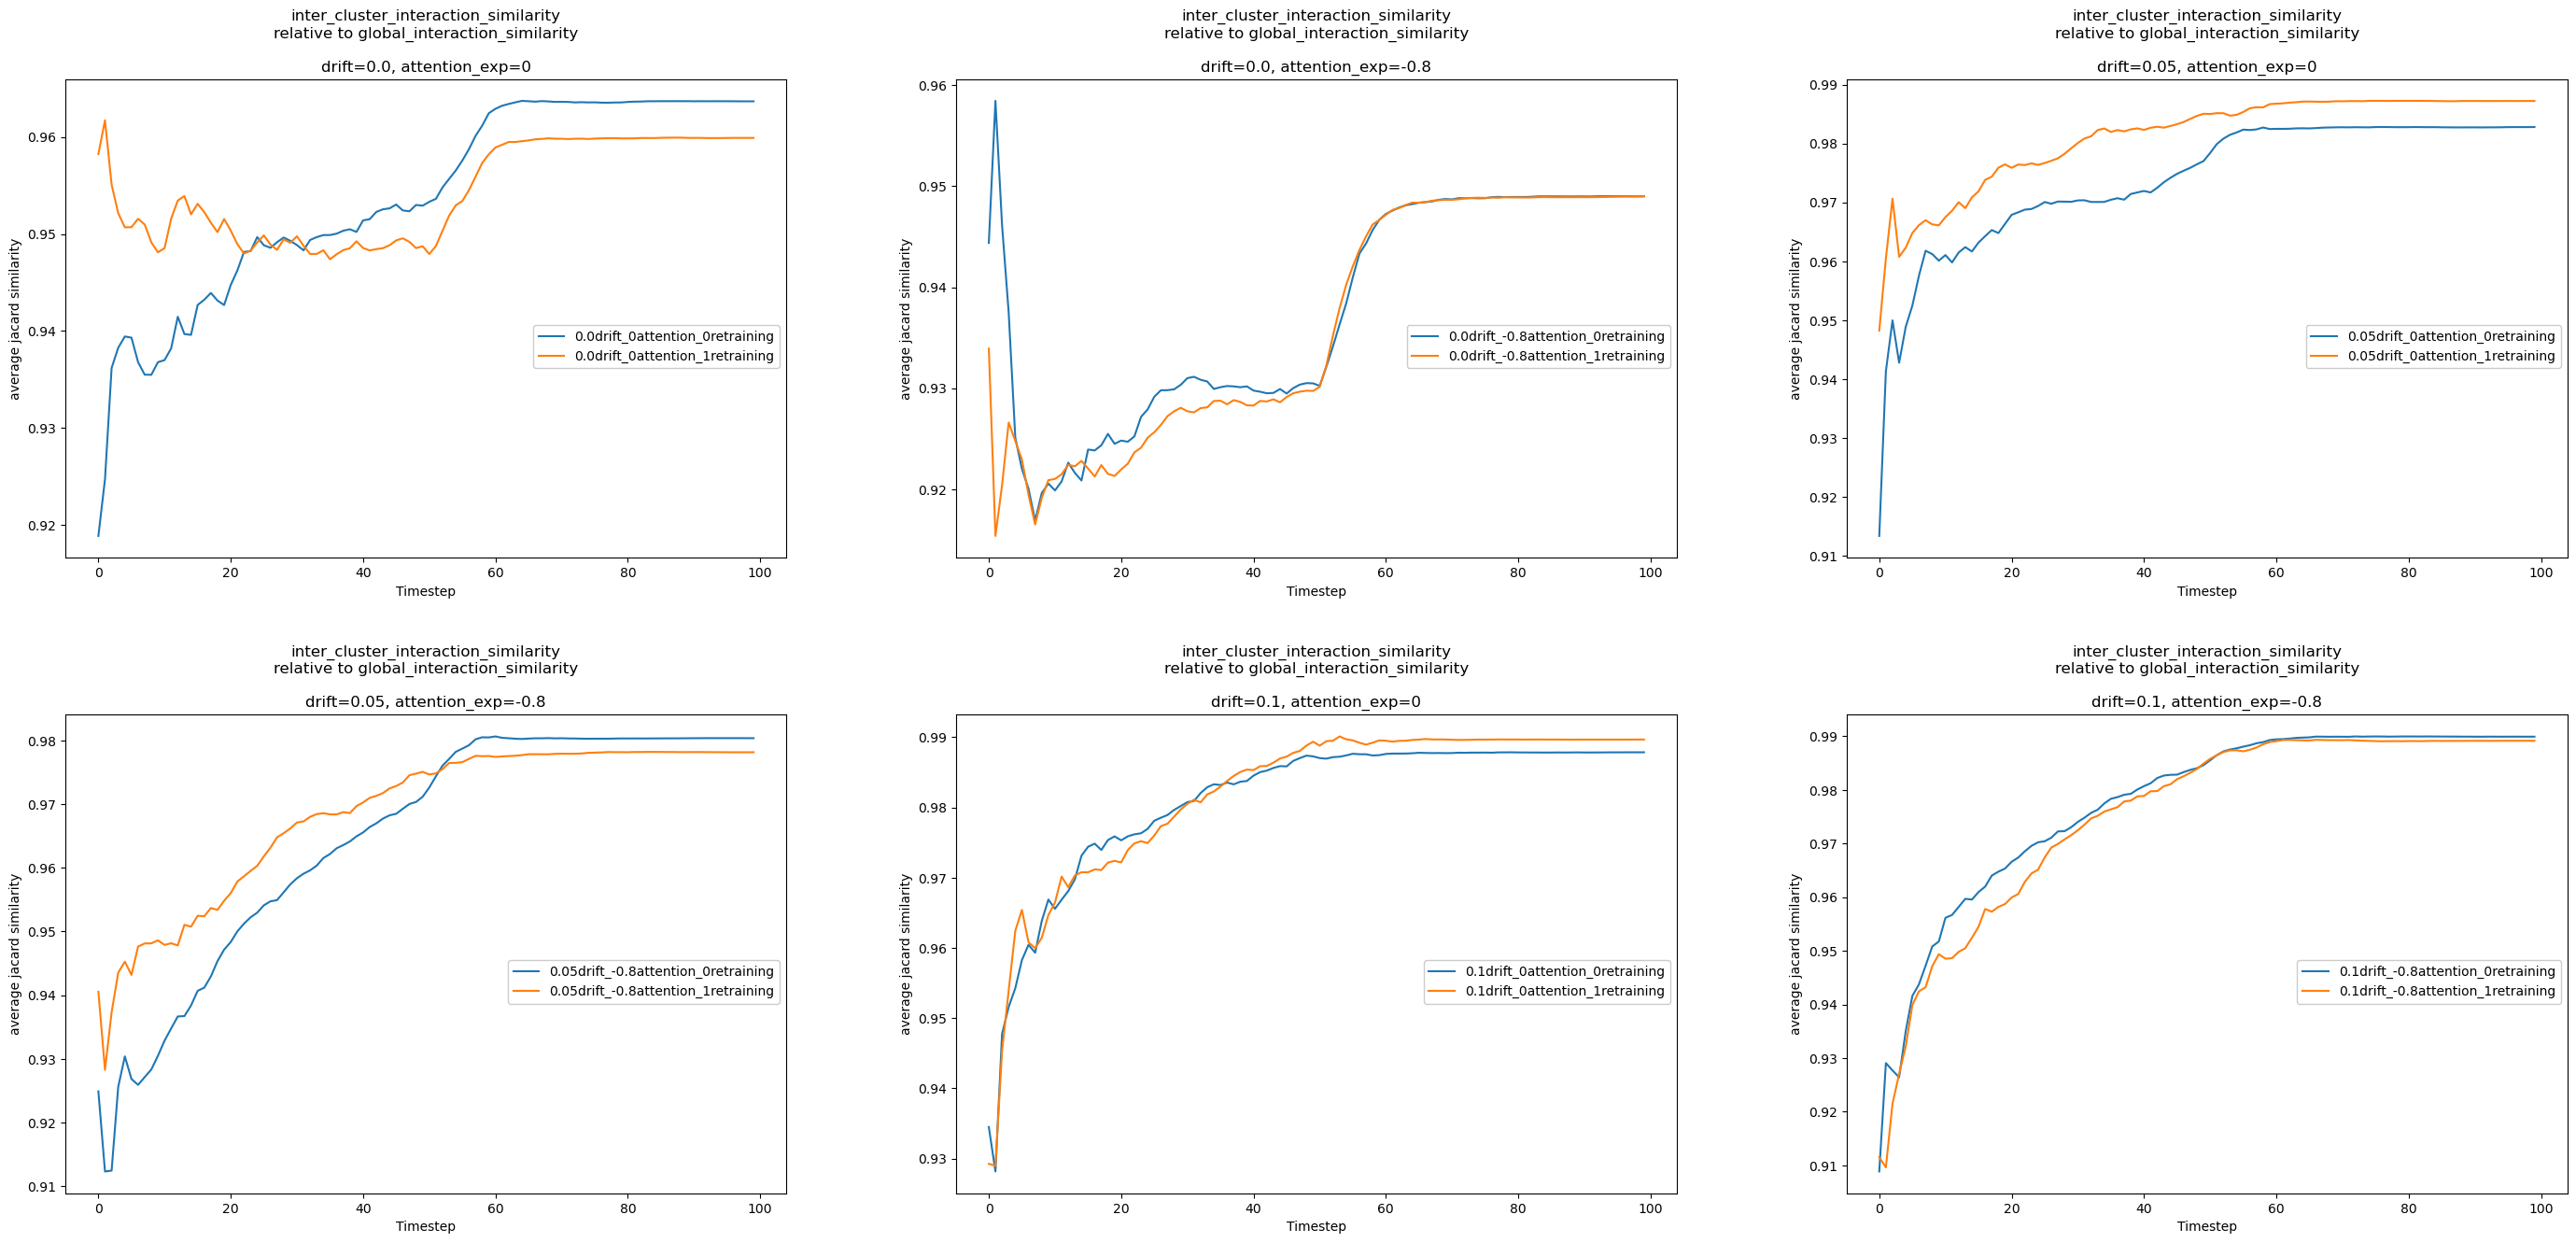

In [27]:
metric_key = "inter_cluster_interaction_similarity"

fig, axs = plt.subplots(2, 3, figsize=(30, 15))
fig.tight_layout(pad=10.0)

for i in range(len(model_key_pairs)):
    curr_ax = axs[int(i >= 3), i%3]
    graph_relative_to_global_by_axis(curr_ax, results, global_metric_key, metric_key, model_key_pairs[i], id_to_readable, mult_sd=0)
    curr_ax.set_ylabel(y_labels[metric_key])
    curr_ax.set_xlabel("Timestep")
    curr_ax.set_title(f"{metric_key}\nrelative to {global_metric_key}\n\ndrift={models[model_key_pairs[i][0]][0]}, attention_exp={models[model_key_pairs[i][0]][1]}")

### Graphing **`Intra`** `-Cluster Interaction Similarity` relative to `Global Interaction Simarilty`

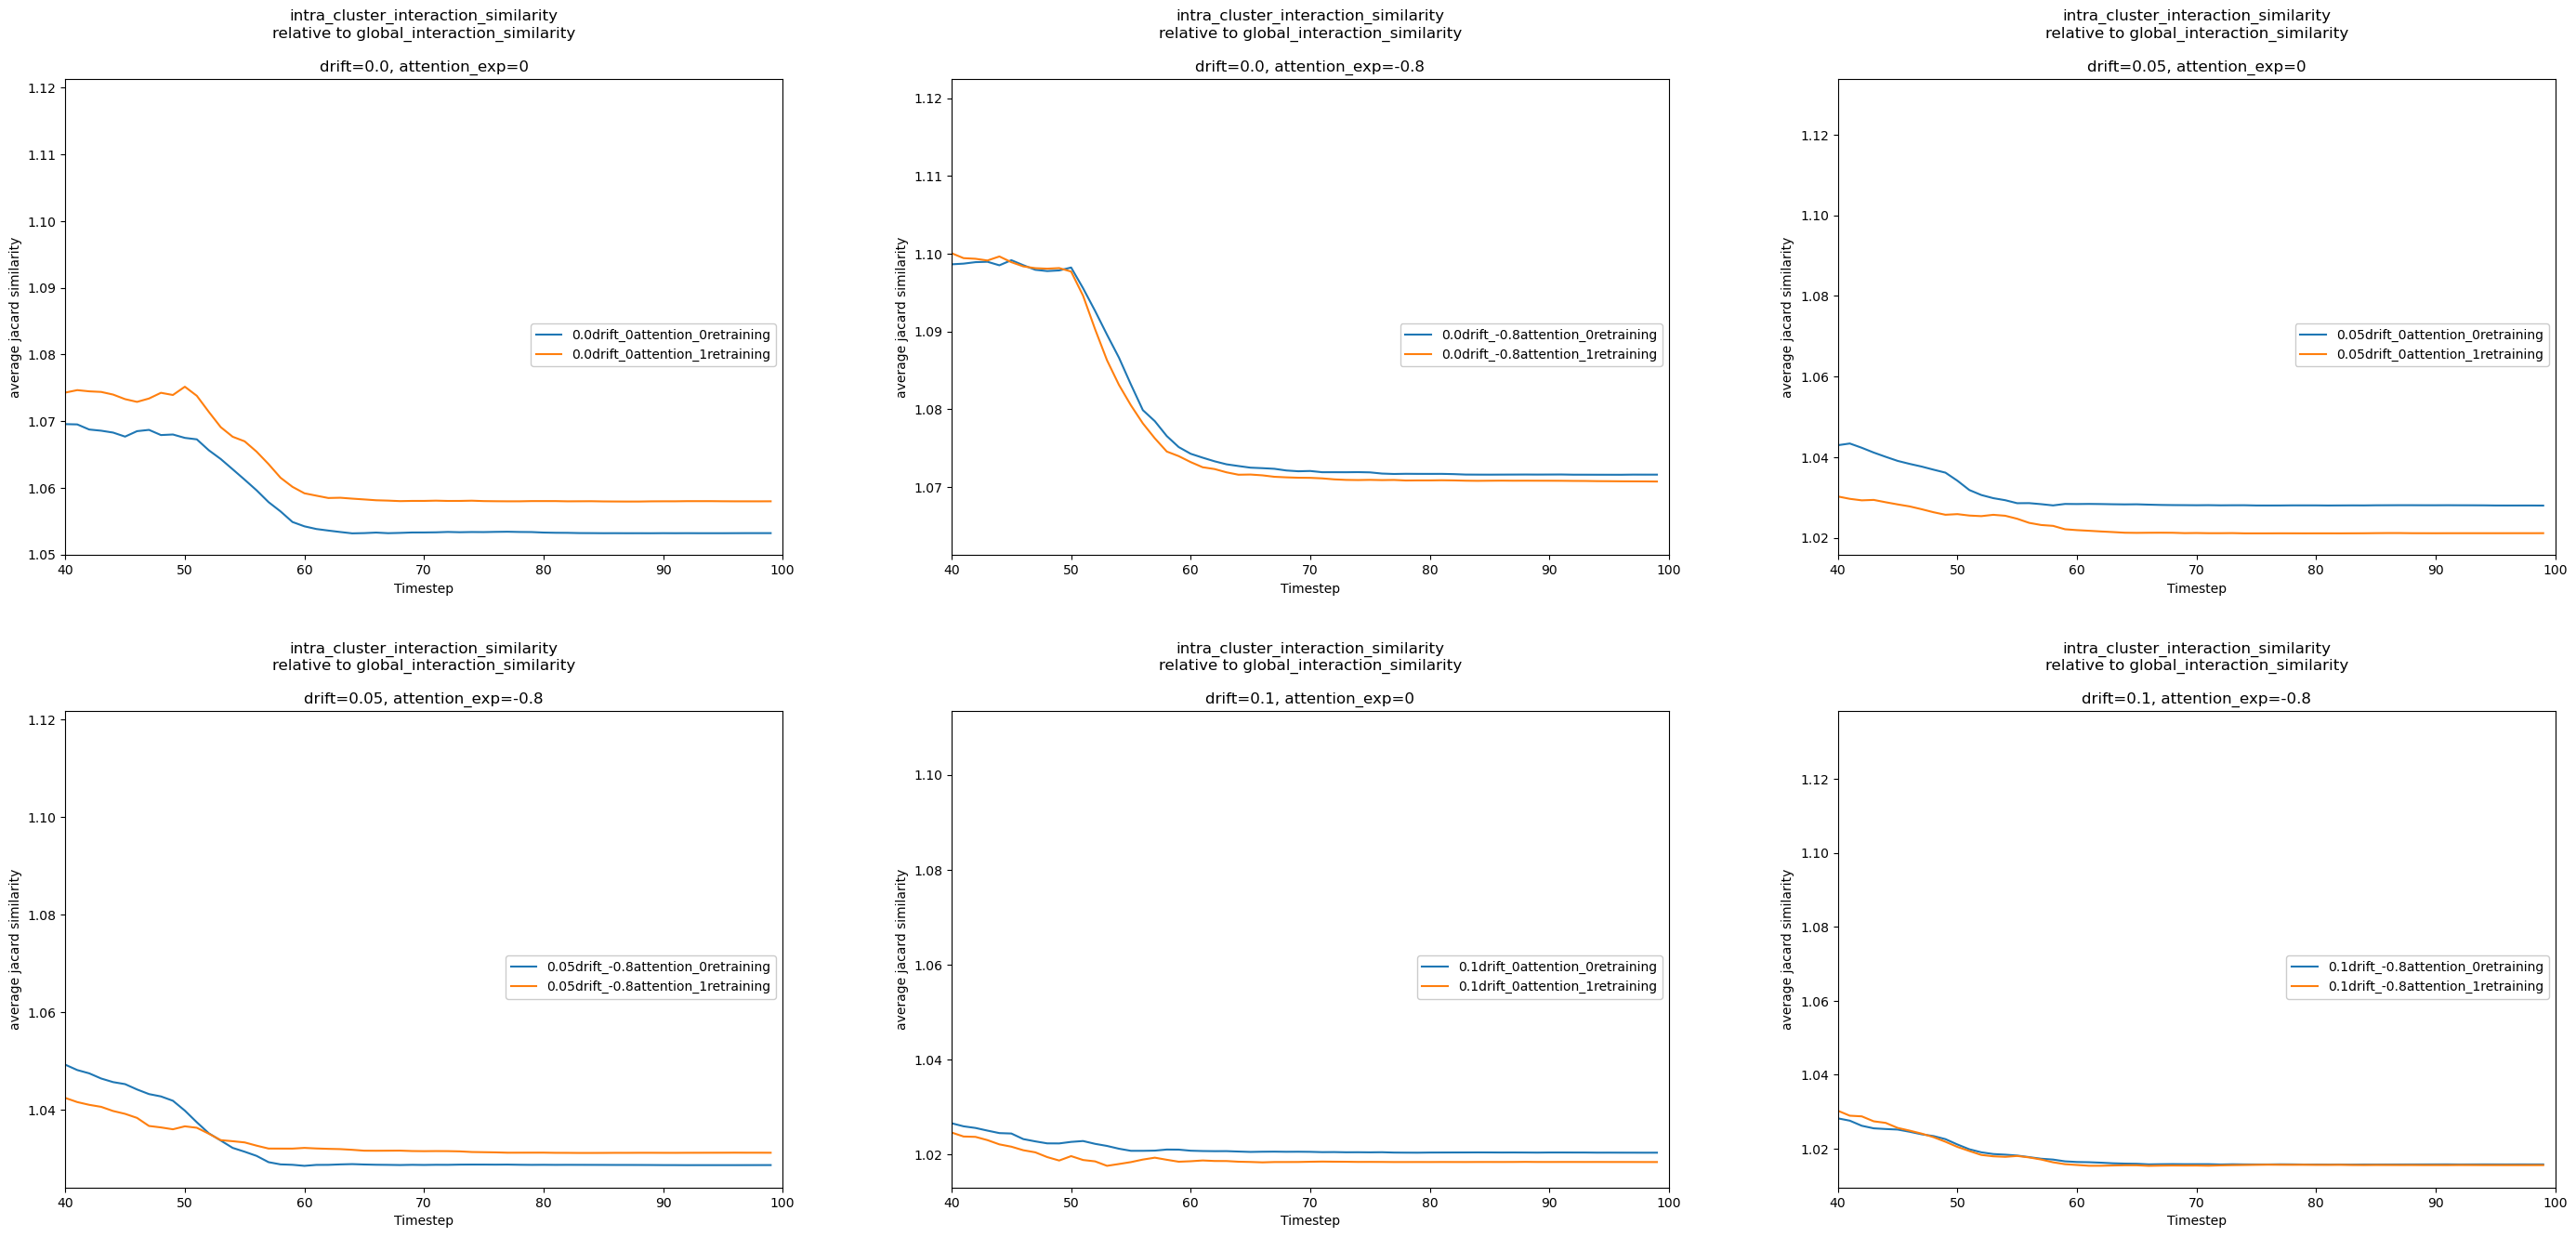

In [35]:
metric_key = "intra_cluster_interaction_similarity"

fig, axs = plt.subplots(2, 3, figsize=(30, 15))
fig.tight_layout(pad=10.0)

for i in range(len(model_key_pairs)):
    curr_ax = axs[int(i >= 3), i%3]
    graph_relative_to_global_by_axis(curr_ax, results, global_metric_key, metric_key, model_key_pairs[i], id_to_readable, mult_sd=0)
    curr_ax.set_ylabel(y_labels[metric_key])
    curr_ax.set_xlabel("Timestep")
    curr_ax.set_title(f"{metric_key}\nrelative to {global_metric_key}\n\ndrift={models[model_key_pairs[i][0]][0]}, attention_exp={models[model_key_pairs[i][0]][1]}")
    # curr_ax.set_ylim(-0.1, 1.75)
    curr_ax.set_xlim(40, 100)